# EDH Filter: Function-Based Implementation

This notebook implements the **Exact Daum-Huang (EDH)** filter using **pure functions** (no classes).

Each function directly corresponds to specific lines in **Algorithm 1** from Ding & Coates (2012).

## Algorithm 1: Original Exact Flow Daum-Huang Filter

```
Initialization:
  1  Draw {x_0^i}_{i=1}^N from the prior p(x_0)
  2  Set x̂_0 and m_0 as the mean; P_0 as the covariance matrix

  3  for k = 1 to T do
  4    Propagate particles x_{k-1}^i = f_k(x_{k-1}^i) + v_k
  5    Calculate the mean value x̄_k
  6    Apply UKF/EKF prediction:
         (m_{k-1|k-1}, P_{k-1|k-1}) → (m_{k|k-1}, P_{k|k-1})
  7    for j = 1, ..., N_λ do
  8      Set λ = j∆λ
  9      Calculate H_x by linearizing γ_k() at x̄_k
 10      Calculate A and b from (8) and (9) using
           P_{k|k-1}, x̄ and H_x
 11      for i = 1, ..., N do
 12        Evaluate dx_k^i/dλ for each particle from (7)
 13        Migrate particles: x_k^i = x_k^i + ∆λ · dx_k^i/dλ
 14      endfor
 15      Re-evaluate x̄_k using the updated particles x_k^i
 16    endfor
 17    Apply UKF/EKF update:
         (m_{k|k-1}, P_{k|k-1}) → (m_{k|k}, P_{k|k})
 18    Estimate x̂_k from the particles x_k^i using P_{k|k}
 19    Optional: redraw particles x_k^i ~ N(x̂_k, P_{k|k})
 20  endfor
```

## References

- **Ding & Coates (2012)**: "Implementation of the Daum-Huang Exact-Flow Particle Filter", IEEE SSP
- **MATLAB Code**: `PFPF/particle_flow/DH_ExactFlow_Filter.m`

## 1. Setup and Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import acoustic model functions
import sys
sys.path.append('Acoustic')
from acoustic_function import (
    initialize_acoustic_model,
    state_transition,
    observation_model,
    compute_observation_jacobian,
    simulate_trajectory
)

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow version: 2.20.0
GPU available: False


## 2. Initialize Acoustic Model

In [2]:
# Initialize acoustic model with default parameters (4 targets, 25 sensors)
model_params = initialize_acoustic_model(n_targets=4)

print(f"Configuration:")
print(f"  Targets: {model_params['n_targets']}")
print(f"  Sensors: {model_params['n_sensors']} (5×5 grid)")
print(f"  State dimension: {model_params['state_dim']}")
print(f"  Surveillance area: {model_params['sim_area_size']}m × {model_params['sim_area_size']}m")
print(f"\nAcoustic Parameters:")
print(f"  Amplitude (Ψ): {model_params['amplitude'].numpy()}")
print(f"  Measurement noise std: {model_params['measurement_noise_std']}")

Configuration:
  Targets: 4
  Sensors: 25 (5×5 grid)
  State dimension: 16
  Surveillance area: 40.0m × 40.0m

Acoustic Parameters:
  Amplitude (Ψ): 10.0
  Measurement noise std: 0.1


## 3. EDH Filter Functions

Each function below corresponds to specific lines in Algorithm 1.

### Function 1: Compute Lambda Steps

**Purpose**: Compute exponentially spaced lambda steps for particle flow.

**Algorithm**: Pre-processing (before Algorithm 1)

**Equations**:
- Step sizes: $\epsilon_j = \epsilon_1 \cdot q^{j-1}$ for $j = 1, ..., N_\lambda$
- Constraint: $\sum_{j=1}^{N_\lambda} \epsilon_j = 1$
- Solution: $\epsilon_1 = \frac{1-q}{1-q^{N_\lambda}}$ where $q > 1$ (typically $q = 1.2$)
- Lambda values: $\lambda_j = \sum_{i=1}^{j} \epsilon_i$

**MATLAB**: Uses exponential spacing in `DH_ExactFlow_Filter.m`

In [3]:
## The below code is correct

In [4]:
def compute_lambda_steps(n_lambda, lambda_ratio):
    """
    Compute exponentially spaced lambda steps.
    
    Args:
        n_lambda: Number of lambda steps (typically 20)
        lambda_ratio: Ratio for exponential spacing (typically 1.2)
    
    Returns:
        lambda_steps: Step sizes ε_j, shape (n_lambda,)
        lambda_values: Cumulative lambda values λ_j, shape (n_lambda,)
    """
    q = lambda_ratio
    n = n_lambda
    
    # Initial step size: ε_1 = (1-q)/(1-q^n)
    epsilon_1 = (1 - q) / (1 - q**n)
    
    # Step sizes: ε_j = ε_1 * q^(j-1) for j=1,...,n
    step_sizes = [epsilon_1 * (q**j) for j in range(n)]
    lambda_steps = tf.constant(step_sizes, dtype=tf.float32)
    
    # Cumulative lambda values: λ_j = Σ_{i=1}^j ε_i
    lambda_values = tf.cumsum(lambda_steps)
    
    return lambda_steps, lambda_values

### Function 2: Initialize Particles

**Algorithm Lines 1-2**

**Purpose**: Draw initial particles from prior distribution.

**Equations**:
- Draw: $x_0^{(i)} \sim \mathcal{N}(x_0, P_0)$ for $i = 1, ..., N$
- Initial mean: $x_0$
- Initial covariance: $P_0 = \text{diag}(\sigma_0^2)$

**MATLAB**: `DH_ExactFlow_Filter.m` lines 21-26

**CORRECTED** - Now matches MATLAB AcousticGaussInit.m implementation

In [5]:
def initialize_particles(model_params, n_particle):
    """
    Initialize particles from Gaussian prior.

    Algorithm Lines 1-2:
      1  Draw {x_0^i}_{i=1}^N from the prior p(x_0)
      2  Set x̂_0 and m_0 as the mean; P_0 as the covariance matrix

    Args:
        model_params: Dictionary from initialize_acoustic_model()
        n_particle: Number of particles

    Returns:
        particles: Initial particles, shape (state_dim, n_particle)
        m0: Random initial mean, shape (state_dim, 1)
        P0: Initial covariance, shape (state_dim, state_dim)
    """
    state_dim = model_params['state_dim']
    x0 = model_params['x0_initial_target_states']  # (state_dim, 1)
    n_targets = model_params['n_targets']
    sim_area_size = model_params['sim_area_size']

    # Initial uncertainty from MATLAB: sigma0 = repmat(10*[1;1;0.1;0.1], nTarget, 1)
    # Per target: [σ_x, σ_y, σ_vx, σ_vy] = [10.0, 10.0, 1.0, 1.0]
    sigma0_single = tf.constant([10.0, 10.0, 1.0, 1.0], dtype=tf.float32)
    sigma0 = tf.tile(sigma0_single, [n_targets])

    # Line 2: P_0 = diag(σ_0^2)
    P0 = tf.linalg.diag(tf.square(sigma0))

    # MATLAB Lines 14-23: Sample random mean m0 and ensure it's within bounds
    # area = [x_min, y_min, x_max, y_max] = [0, 0, 40, 40]
    out_of_bound = True

    while out_of_bound:
        # Line 15: m0 = x0 + sigma0.*randn(dim,1)
        noise = tf.random.normal((state_dim, 1), dtype=tf.float32)
        m0 = x0 + tf.expand_dims(sigma0, 1) * noise

        # Lines 17-22: Check if all target positions are within surveillance region
        # Extract x and y positions for all targets
        x_positions = m0[0::4, 0]  # indices 0, 4, 8, 12, ... (x positions)
        y_positions = m0[1::4, 0]  # indices 1, 5, 9, 13, ... (y positions)

        # Check bounds: all positions should be in [0, sim_area_size]
        x_in_bounds = tf.reduce_all(x_positions >= 0.0) and tf.reduce_all(x_positions <= sim_area_size)
        y_in_bounds = tf.reduce_all(y_positions >= 0.0) and tf.reduce_all(y_positions <= sim_area_size)

        if x_in_bounds and y_in_bounds:
            out_of_bound = False

    # Line 28: Sample particles around m0
    # xp = m0*ones(1,nParticle) + bsxfun(@times,sigma0,randn(dim,nParticle))
    noise = tf.random.normal((state_dim, n_particle), dtype=tf.float32)
    particles = m0 + tf.expand_dims(sigma0, 1) * noise

    return particles, m0, P0

### Function 3: Propagate Particles

**Algorithm Line 4**

**Purpose**: Propagate particles through motion model.

**Equation**:
$$x_k^{(i)} = \Phi x_{k-1}^{(i)} + w_k^{(i)}, \quad w_k^{(i)} \sim \mathcal{N}(0, Q)$$

where:
- $\Phi$ is the state transition matrix (constant velocity model)
- $Q$ is the process noise covariance

**MATLAB**: `DH_ExactFlow_Filter.m` line 63

In [6]:
# the code below is correct

In [7]:
def propagate_particles(particles, model_params):
    """
    Propagate particles through motion model.
    
    Algorithm Line 4:
      4  Propagate particles x_{k-1}^i = f_k(x_{k-1}^i) + v_k
    
    Equation:
      x_k = Φ * x_{k-1} + w_k,  where w_k ~ N(0, Q)
    
    Args:
        particles: Current particles, shape (state_dim, n_particle)
        model_params: Dictionary with 'Phi' and 'Q'
    
    Returns:
        particles_pred: Predicted particles, shape (state_dim, n_particle)
    """
    state_dim = model_params['state_dim']
    Phi = model_params['Phi']  # State transition matrix
    Q = model_params['Q']      # Process noise covariance
    n_particle = tf.shape(particles)[1]
    
    # Linear propagation: x_k = Φ * x_{k-1}
    particles_pred = tf.matmul(Phi, particles)
    
    # Add process noise: w_k ~ N(0, Q)
    Q_chol = tf.linalg.cholesky(Q)
    noise = tf.matmul(Q_chol, tf.random.normal((state_dim, n_particle), dtype=tf.float32))
    
    return particles_pred + noise

### Function 4: Estimate Covariance from Particles

**Algorithm Lines 6 and 17**

**Purpose**: Estimate covariance matrix from particle spread.

**Equation**:
$$P = \frac{1}{N-1} \sum_{i=1}^N (x^{(i)} - \bar{x})(x^{(i)} - \bar{x})^T$$

where $\bar{x} = \frac{1}{N} \sum_{i=1}^N x^{(i)}$

**Used for**:
- Line 6: $P_{k|k-1}$ (prior covariance) - computed from predicted particles
- Line 17: $P_{k|k}$ (posterior covariance) - computed from updated particles

**MATLAB**: `cov(particles')` in lines 53, 67, 119

In [8]:
## The below code is correct as it is basic idea for generate variance

In [9]:
def estimate_covariance(particles):
    """
    Estimate covariance from particles.
    
    Algorithm Line 6 (prediction): P_{k|k-1}
    Algorithm Line 17 (update): P_{k|k}
    
    Equation:
      P = (1/(N-1)) * Σ (x_i - x̄)(x_i - x̄)^T
    
    Args:
        particles: Particles, shape (state_dim, n_particle)
    
    Returns:
        P: Covariance matrix, shape (state_dim, state_dim)
    """
    # Compute mean
    mean = tf.reduce_mean(particles, axis=1, keepdims=True)
    
    # Center particles
    centered = particles - mean
    
    # Covariance: P = (1/(N-1)) * centered @ centered^T
    n_particles = tf.cast(tf.shape(particles)[1], tf.float32)
    P = tf.matmul(centered, tf.transpose(centered)) / (n_particles - 1.0)
    
    # Add small regularization for numerical stability
    P = P + 1e-6 * tf.eye(tf.shape(P)[0], dtype=tf.float32)
    
    return P

### Function 5: Compute Flow Parameters A and b

**Algorithm Line 10**

**Purpose**: Compute flow matrix $A(\lambda)$ and flow vector $b(\lambda)$ for particle flow.

**Equations** (from Ding & Coates 2012, Equations 8 and 9):

$$A(\lambda) = -\frac{1}{2} P H^T (\lambda H P H^T + R)^{-1} H$$

$$b(\lambda) = (I + 2\lambda A)[(I + \lambda A) P H^T R^{-1} (z - e) + A\bar{x}]$$

where:
- $H = \frac{\partial h}{\partial x}|_{\bar{x}}$ is the observation Jacobian
- $e = h(\bar{x}) - H\bar{x}$ is the linearization residual
- $z$ is the current measurement
- $P$ is the covariance (should be $P_{k|k-1}$)
- $R$ is the measurement noise covariance

**MATLAB**: `calculateSlope()` function

In [10]:
# the code below is correct

In [11]:
def compute_flow_parameters(x, x_bar, P, measurement, lam, model_params, use_local=False):
    """
    Compute flow parameters A and b for particle x.
    
    Algorithm Line 10:
      10  Calculate A and b from (8) and (9) using P_{k|k-1}, x̄ and H_x
    
    Equations:
      A(λ) = -1/2 * P * H^T * (λ*H*P*H^T + R)^{-1} * H
      b(λ) = (I + 2λA) * [(I + λA) * P*H^T*R^{-1}*(z-e) + A*x̄]
    
    Args:
        x: Particle position (state_dim, 1) - used for linearization
        x_bar: Mean trajectory (state_dim, 1) - used in b computation
        P: Covariance (state_dim, state_dim) - should be P_{k|k-1}
        measurement: Current measurement z, shape (n_sensor, 1)
        lam: Current lambda value (scalar)
        model_params: Dictionary with observation model
        use_local: If True, linearize at x (local); if False, linearize at x_bar (global)
    
    Returns:
        A: Flow matrix, shape (state_dim, state_dim)
        b: Flow vector, shape (state_dim,)
    """
    state_dim = tf.shape(P)[0]
    R = model_params['R']
    
    # Algorithm Line 9: Calculate H_x by linearizing at x̄_k (or x_i for local)
    linearization_point = x if use_local else x_bar
    H = compute_observation_jacobian(linearization_point, model_params)
    
    # Compute h(x̄) and linearization residual: e = h(x̄) - H*x̄
    h_x_bar = observation_model(x_bar, model_params, no_noise=True)
    h_x_bar = tf.squeeze(h_x_bar, axis=1)  # (n_sensor,)
    e = h_x_bar - tf.linalg.matvec(H, tf.squeeze(x_bar, axis=1))
    
    # Compute H*P*H^T
    HPHt = tf.matmul(tf.matmul(H, P), tf.transpose(H))
    
    # Innovation covariance: S = λ*H*P*H^T + R
    S = lam * HPHt + R
    S_inv = tf.linalg.inv(S)
    
    # Compute P*H^T
    PHt = tf.matmul(P, tf.transpose(H))
    
    # Equation (8): Flow matrix A = -0.5 * P*H^T * S^{-1} * H
    A = -0.5 * tf.matmul(tf.matmul(PHt, S_inv), H)
    
    # Innovation: z - e
    innovation = tf.squeeze(measurement, axis=1) - e
    
    # Compute R^{-1}*(z - e)
    R_inv = tf.linalg.inv(R)
    R_inv_innov = tf.linalg.matvec(R_inv, innovation)
    
    # Identity matrix
    I = tf.eye(state_dim, dtype=tf.float32)
    
    # (I + λA) and (I + 2λA)
    I_plus_lam_A = I + lam * A
    I_plus_2lam_A = I + 2 * lam * A
    
    # Equation (9): Flow vector b
    # First term: (I + λA) * P*H^T * R^{-1}*(z - e)
    term1 = tf.linalg.matvec(tf.matmul(I_plus_lam_A, PHt), R_inv_innov)
    # Second term: A * x̄
    term2 = tf.linalg.matvec(A, tf.squeeze(x_bar, axis=1))
    # Combined: b = (I + 2λA) * [term1 + term2]
    b = tf.linalg.matvec(I_plus_2lam_A, term1 + term2)
    
    return A, b

### Function 6: Particle Flow

**Algorithm Lines 7-16**

**Purpose**: Migrate particles from prior to posterior using exact flow.

**Flow ODE** (Equation 7):
$$\frac{dx}{d\lambda} = A(\lambda) x + b(\lambda)$$

**Numerical integration** (Euler method):
$$x^{(j+1)} = x^{(j)} + \epsilon_j [A(\lambda_j) x^{(j)} + b(\lambda_j)]$$

where:
- $\epsilon_j$ is the step size at lambda step $j$
- $\lambda_j$ is the cumulative lambda value
- Integration from $\lambda = 0$ (prior) to $\lambda = 1$ (posterior)

**MATLAB**: `DH_ExactFlow_Filter.m` lines 78-101

In [12]:
# the code below is correct for EDH

In [13]:
def particle_flow(particles, measurement, P_pred, lambda_steps, lambda_values, 
                  model_params, use_local=False):
    """
    Migrate particles from prior to posterior using exact flow.
    
    Algorithm Lines 7-16:
      7  for j = 1, ..., N_λ do
      8    Set λ = j∆λ
      9    Calculate H_x by linearizing γ_k() at x̄_k
     10    Calculate A and b from (8) and (9)
     11    for i = 1, ..., N do
     12      Evaluate dx_k^i/dλ for each particle from (7)
     13      Migrate particles: x_k^i = x_k^i + ∆λ · dx_k^i/dλ
     14    endfor
     15    Re-evaluate x̄_k using the updated particles x_k^i
     16  endfor
    
    Flow Equation (7):
      dx/dλ = A(λ) * x + b(λ)
    
    Euler Update:
      x = x + ε_j * [A(λ_j) * x + b(λ_j)]
    
    Args:
        particles: Predicted particles, shape (state_dim, n_particle)
        measurement: Current measurement, shape (n_sensor, 1)
        P_pred: Prior covariance P_{k|k-1}, shape (state_dim, state_dim)
        lambda_steps: Step sizes ε_j, shape (n_lambda,)
        lambda_values: Cumulative lambda values λ_j, shape (n_lambda,)
        model_params: Dictionary with observation model
        use_local: If True, use local linearization (Algorithm 2)
                   If False, use global linearization (Algorithm 1)
    
    Returns:
        particles_flowed: Updated particles, shape (state_dim, n_particle)
    """
    # Initialize flow
    eta = tf.identity(particles)  # Current particle positions
    n_particle = tf.shape(particles)[1]
    n_lambda = len(lambda_steps)
    
    # Algorithm Line 7: for j = 1, ..., N_λ do
    for j in range(n_lambda):
        # Algorithm Line 8: Set λ = j∆λ
        epsilon_j = lambda_steps[j]   # Step size
        lambda_j = lambda_values[j]   # Current lambda value
        
        # Algorithm Line 5 & 15: Calculate/re-evaluate mean x̄_k
        eta_bar = tf.reduce_mean(eta, axis=1, keepdims=True)
        
        if use_local:
            # Modified Algorithm 2: Local linearization at each particle
            # Algorithm Line 11: for i = 1, ..., N do
            slopes = []
            for i in range(n_particle):
                x_i = tf.expand_dims(eta[:, i], 1)  # (state_dim, 1)
                
                # Lines 9-10: Compute A_i, b_i for THIS particle
                A_i, b_i = compute_flow_parameters(x_i, eta_bar, P_pred, measurement, 
                                                   lambda_j, model_params, use_local=True)
                
                # Line 12: Evaluate dx^i/dλ = A_i * x^i + b_i
                slope_i = tf.linalg.matvec(A_i, tf.squeeze(x_i)) + b_i
                slopes.append(slope_i)
            
            slopes = tf.stack(slopes, axis=1)  # (state_dim, n_particle)
        else:
            # Original Algorithm 1: Global linearization at mean
            # Lines 9-10: Compute A, b ONCE at mean x̄_k
            A, b = compute_flow_parameters(eta_bar, eta_bar, P_pred, measurement,
                                          lambda_j, model_params, use_local=False)
            
            # Line 12: Evaluate dx^i/dλ = A * x^i + b for ALL particles
            slopes = tf.matmul(A, eta) + tf.expand_dims(b, 1)
        
        # Algorithm Line 13: Migrate particles x^i = x^i + ∆λ · (dx^i/dλ)
        eta = eta + epsilon_j * slopes
    
    return eta

### Function 7: EDH Filter Step

**Algorithm Lines 4-18**

**Purpose**: Perform one complete filter step (prediction + update).

**Steps**:
1. **Line 4**: Propagate particles (prediction)
2. **Line 6**: Compute $P_{k|k-1}$ (prior covariance)
3. **Lines 7-16**: Particle flow using $P_{k|k-1}$
4. **Line 17**: Compute $P_{k|k}$ (posterior covariance)
5. **Line 18**: Estimate state from particles

**MATLAB**: `DH_ExactFlow_Filter.m` main loop

In [14]:
def edh_filter_step(particles, measurement, lambda_steps, lambda_values, 
                    model_params, use_local=False):
    """
    Perform one EDH filter step.
    
    Algorithm Lines 4-18:
      4  Propagate particles
      5  Calculate mean
      6  Apply UKF/EKF prediction → P_{k|k-1}
      7-16  Particle flow (using P_{k|k-1})
      17  Apply UKF/EKF update → P_{k|k}
      18  Estimate x̂_k
    
    Args:
        particles: Current particles, shape (state_dim, n_particle)
        measurement: Current measurement, shape (n_sensor, 1)
        lambda_steps: Step sizes, shape (n_lambda,)
        lambda_values: Lambda values, shape (n_lambda,)
        model_params: Dictionary with model parameters
        use_local: If True, use local linearization
    
    Returns:
        particles_updated: Updated particles, shape (state_dim, n_particle)
        mean_estimate: State estimate, shape (state_dim,)
        P_updated: Posterior covariance P_{k|k}, shape (state_dim, state_dim)
    """
    # Algorithm Line 4: PREDICTION - Propagate particles
    particles_pred = propagate_particles(particles, model_params)
    
    # Algorithm Line 6: Compute P_{k|k-1} (prior/predicted covariance)
    # This is the covariance AFTER prediction, BEFORE update
    P_pred = estimate_covariance(particles_pred)
    
    # Algorithm Lines 7-16: UPDATE - Particle flow from prior to posterior
    # Uses P_{k|k-1} throughout the flow
    particles_flowed = particle_flow(particles_pred, measurement, P_pred, 
                                     lambda_steps, lambda_values, 
                                     model_params, use_local)
    
    # Algorithm Line 17: Compute P_{k|k} (posterior/updated covariance)
    # This is the covariance AFTER incorporating measurement
    P_updated = estimate_covariance(particles_flowed)
    
    # Algorithm Line 18: ESTIMATE - Compute state estimate
    mean_estimate = tf.reduce_mean(particles_flowed, axis=1)
    
    return particles_flowed, mean_estimate, P_updated

### Function 8: Run EDH Filter

**Algorithm Line 3 (main loop)**

**Purpose**: Run EDH filter on full measurement sequence.

**MATLAB**: `DH_ExactFlow_Filter.m` main function

In [15]:
def run_edh_filter(measurements, model_params, n_particle=100, n_lambda=20, 
                   lambda_ratio=1.2, use_local=False):
    """
    Run EDH filter on measurement sequence.
    
    Algorithm Main Loop:
      1-2  Initialize particles and covariance
      3    for k = 1 to T do
             [Lines 4-19: filter step]
           endfor
    
    Args:
        measurements: Measurements, shape (n_sensor, T)
        model_params: Dictionary with model parameters
        n_particle: Number of particles
        n_lambda: Number of lambda steps
        lambda_ratio: Exponential spacing ratio
        use_local: If True, use local linearization (Algorithm 2)
                   If False, use global linearization (Algorithm 1)
    
    Returns:
        estimates: State estimates, shape (state_dim, T)
        particles_all: All particles, shape (state_dim, n_particle, T)
        covariances_all: All covariances P_{k|k}, shape (state_dim, state_dim, T)
    """
    T = tf.shape(measurements)[1].numpy()
    
    print(f"\nRunning EDH Filter:")
    print(f"  Particles: {n_particle}")
    print(f"  Lambda steps: {n_lambda}")
    print(f"  Lambda ratio: {lambda_ratio}")
    print(f"  Linearization: {'Local (Algorithm 2)' if use_local else 'Global (Algorithm 1)'}")
    print(f"  Time steps: {T}")
    
    # Pre-compute lambda steps
    lambda_steps, lambda_values = compute_lambda_steps(n_lambda, lambda_ratio)
    
    # Algorithm Lines 1-2: Initialize particles and covariance
    particles, m0, P = initialize_particles(model_params, n_particle)
    
    # Storage
    estimates_list = []
    particles_list = []
    covariances_list = []
    
    # Algorithm Line 3: for k = 1 to T do
    print("\nProcessing time steps...")
    for t in range(T):
        if (t + 1) % 10 == 0:
            print(f"  Step {t+1}/{T}")
        
        z_t = tf.expand_dims(measurements[:, t], 1)  # (n_sensor, 1)
        
        # Filter step - includes Lines 4-18
        particles, mean_estimate, P = edh_filter_step(
            particles, z_t, lambda_steps, lambda_values, model_params, use_local
        )
        
        # Store results
        estimates_list.append(tf.expand_dims(mean_estimate, 1))
        particles_list.append(tf.expand_dims(particles, 2))
        covariances_list.append(tf.expand_dims(P, 2))
    
    # Concatenate results
    estimates = tf.concat(estimates_list, axis=1)
    particles_all = tf.concat(particles_list, axis=2)
    covariances_all = tf.concat(covariances_list, axis=2)
    
    print("\nEDH filter completed successfully!")
    print(f"  Estimates shape: {estimates.shape}")
    print(f"  Particles shape: {particles_all.shape}")
    print(f"  Covariances shape: {covariances_all.shape}")
    
    return estimates, particles_all, covariances_all

## 4. Generate Ground Truth Data

In [16]:
# Generate ground truth trajectory and measurements
T = 20  # Number of time steps
ground_truth, measurements = simulate_trajectory(model_params, T, keep_in_bounds=True)

## 5. Run EDH Filter

Now we run the filter using the function-based implementation.

In [17]:
# Run EDH filter with global linearization (Algorithm 1)
edh_estimates, edh_particles, edh_covariances = run_edh_filter(
    measurements=measurements,
    model_params=model_params,
    n_particle=100,
    n_lambda=20,
    lambda_ratio=1.2,
    use_local=False  # Algorithm 1: Global linearization
)


Running EDH Filter:
  Particles: 100
  Lambda steps: 20
  Lambda ratio: 1.2
  Linearization: Global (Algorithm 1)
  Time steps: 20

Processing time steps...
  Step 10/20
  Step 20/20

EDH filter completed successfully!
  Estimates shape: (16, 20)
  Particles shape: (16, 100, 20)
  Covariances shape: (16, 16, 20)


## 6. Compute Errors

In [18]:
def compute_position_error(estimates, ground_truth, n_targets):
    """Compute position error for each target."""
    errors = []
    
    for i in range(n_targets):
        x_idx = i * 4
        y_idx = i * 4 + 1
        
        x_err = estimates[x_idx, :] - ground_truth[x_idx, :]
        y_err = estimates[y_idx, :] - ground_truth[y_idx, :]
        
        error = tf.sqrt(x_err**2 + y_err**2)
        errors.append(error)
    
    errors = tf.stack(errors, axis=0)  # (n_targets, T)
    mean_error = tf.reduce_mean(errors, axis=0)  # (T,)
    
    return errors, mean_error

# Compute errors
edh_errors, edh_mean_error = compute_position_error(
    edh_estimates, ground_truth[:,1:], model_params['n_targets']
)

# Overall RMSE
rmse = tf.sqrt(tf.reduce_mean((edh_estimates - ground_truth[:,1:])**2))

print("="*60)
print("EDH Filter Performance")
print("="*60)
print(f"Overall RMSE: {rmse.numpy():.4f} m")
print(f"Mean position error (final): {edh_mean_error[-1].numpy():.4f} m")
print(f"Mean position error (average): {tf.reduce_mean(edh_mean_error).numpy():.4f} m")
print("\nPer-target average errors:")
for i in range(model_params['n_targets']):
    avg_err = tf.reduce_mean(edh_errors[i]).numpy()
    print(f"  Target {i+1}: {avg_err:.4f} m")
print("="*60)

EDH Filter Performance
Overall RMSE: 4.9198 m
Mean position error (final): 18.2048 m
Mean position error (average): 7.8587 m

Per-target average errors:
  Target 1: 8.9305 m
  Target 2: 6.1340 m
  Target 3: 8.7101 m
  Target 4: 7.6604 m


## 7. Visualize Results

/var/folders/fr/7vt2v5bs1f37tzqpnrrq0l880000gn/T/ipykernel_60475/655899278.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,


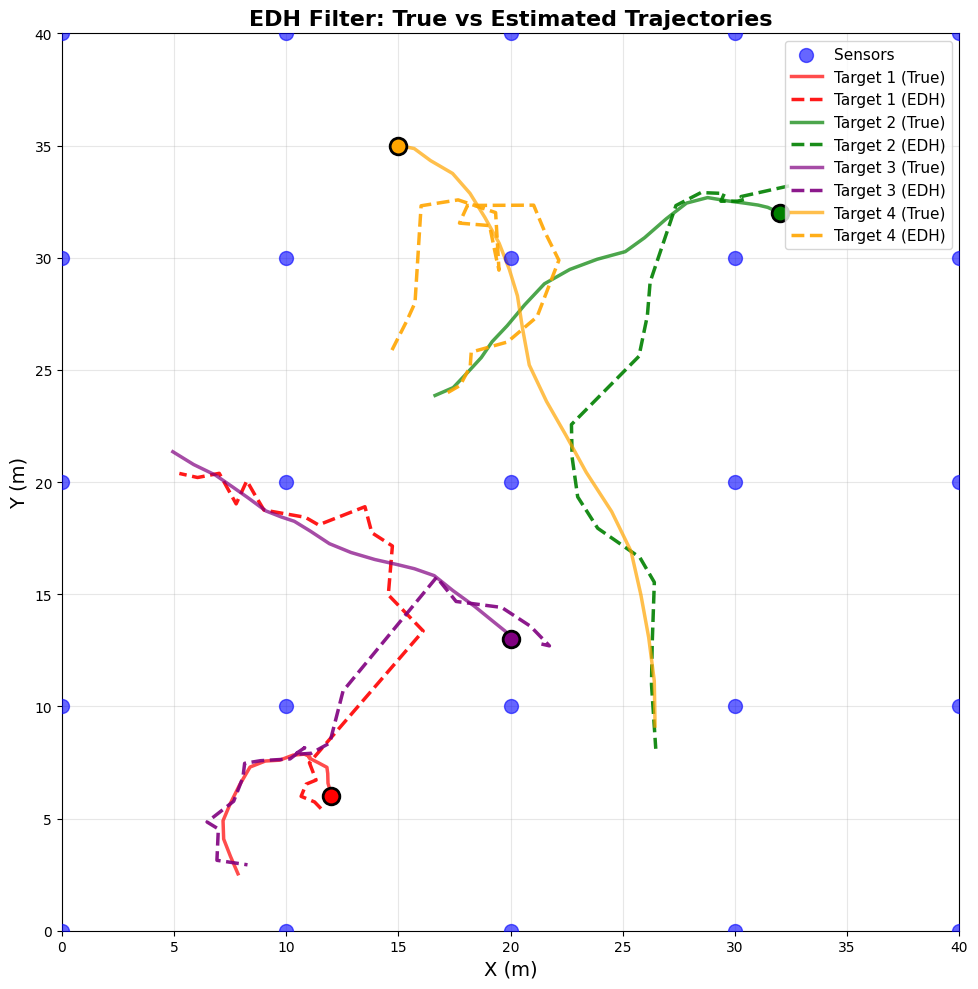

In [19]:
# Plot estimated trajectories
fig, ax = plt.subplots(figsize=(11, 10))

# Plot sensors
sensors = model_params['sensor_positions'].numpy()
ax.scatter(sensors[:, 0], sensors[:, 1], 
          c='blue', marker='o', s=100, label='Sensors', alpha=0.6, zorder=5)

colors = ['red', 'green', 'purple', 'orange']
gt = ground_truth.numpy()
est = edh_estimates.numpy()

for i in range(model_params['n_targets']):
    x_idx = i * 4
    y_idx = i * 4 + 1
    
    # Ground truth
    x_true = gt[x_idx, :]
    y_true = gt[y_idx, :]
    ax.plot(x_true, y_true, '-', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (True)', alpha=0.7)
    
    # Estimates
    x_est = est[x_idx, :]
    y_est = est[y_idx, :]
    ax.plot(x_est, y_est, '--', color=colors[i], linewidth=2.5,
           label=f'Target {i+1} (EDH)', alpha=0.9, linestyle='dashed')
    
    # Mark start
    ax.plot(x_true[0], y_true[0], 'o', color=colors[i], 
           markersize=12, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('X (m)', fontsize=14)
ax.set_ylabel('Y (m)', fontsize=14)
ax.set_title('EDH Filter: True vs Estimated Trajectories', fontsize=16, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, model_params['sim_area_size']])
ax.set_ylim([0, model_params['sim_area_size']])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 8. Summary: Function-to-Algorithm Mapping

| Function | Algorithm Lines | Purpose |
|----------|----------------|----------|
| `compute_lambda_steps()` | Pre-processing | Exponential spacing for lambda |
| `initialize_particles()` | 1-2 | Draw particles from prior |
| `propagate_particles()` | 4 | Motion model prediction |
| `estimate_covariance()` | 6, 17 | Compute P_{k\|k-1} and P_{k\|k} |
| `compute_flow_parameters()` | 9-10 | Compute A(λ) and b(λ) |
| `particle_flow()` | 7-16 | Migrate particles using flow |
| `edh_filter_step()` | 4-18 | One complete filter iteration |
| `run_edh_filter()` | 1-20 | Full filter on sequence |

### Key Points:

1. **Dual Covariance Computation**:
   - `estimate_covariance(particles_pred)` → P_{k|k-1} (Line 6)
   - `estimate_covariance(particles_flowed)` → P_{k|k} (Line 17)

2. **Flow Uses Prior Covariance**:
   - `particle_flow()` receives P_{k|k-1} as input
   - This covariance is used throughout the lambda loop

3. **Local vs Global**:
   - `use_local=False`: Algorithm 1 (global linearization at mean)
   - `use_local=True`: Algorithm 2 (local linearization at each particle)

4. **Verification**:
   - Each function has clear docstring linking to algorithm lines
   - Mathematical equations are included in comments
   - Easy to trace and verify against the paper